# Chebyshev補間の最大・最小値

本稿ではChebyshev補間で与えられた関数

$$
p(x) = \sum_{n=0}^{M-1}a_n T_n(x)
$$

の最大・最小値を精度保証付きで求める方法を紹介する。Chebyshev補間は定義域全体にわたって大域的に定義される関数近似であるため、関数値の最大最小が以下の方法で計算できる。

1. Chebyshev係数から[Chebyshev補間の微分](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebdiff.html)を計算する
1. 微分した[Chebyshev補間の零点を計算](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebroot.html)し、極大値・極小値を求める
1. 元のChebyshev補間の端点の値と極大値・極小値を比較し、最大・最小値を求める


**注**　与えた関数 $f(x)$ に対して、Chebyshev補間 $p(x)$ を行って得られたChebyshev係数を使用して計算をする。すなわち、関数 $f(x)$ の真の最大・最小値ではない可能性があることに注意する。一方で、$f(x)$ の区間包含をChebyshev補間で得られている場合は、真の最大・最小値が精度保証付き数値計算できる。

In [1]:
versioninfo()

Julia Version 1.10.0
Commit 3120989f39b (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 8 × Apple M2
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
  Threads: 2 on 4 virtual cores


In [2]:
using Pkg
Pkg.status("IntervalArithmetic")

Status `~/.julia/environments/v1.10/Project.toml`
⌃ [d1acc4aa] IntervalArithmetic v0.22.8
Info Packages marked with ⌃ have new versions available and may be upgradable.


はじめにChebyshev補間は、[Chebyshev_series.ipynb](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebyshev_series.html)で作成した`Cheb`関数を使用することで、関数を適切な多項式の数で補間することができる。

In [3]:
include("FourierChebyshev.jl")
using SpecialFunctions
f(x) = exp(erf(x^2) + x .^ 5) .* sinpi(5x) + x
# f(x) = sinpi(x)
a = cheb(f)

53-element Vector{Float64}:
  0.2865440445829357
  1.821930890578812
  0.4531346547780721
  0.5336937242932023
  0.12343939865743864
 -0.06026470100896458
 -0.26786478833537686
 -0.7688401036292165
 -0.4383754816956904
 -0.9204707563479828
 -0.2511068079866793
  0.03585451010081118
  0.023769696359959604
  ⋮
  7.973477433864673e-11
  4.911144407815371e-12
 -2.317723877404143e-11
  1.2748444661037084e-11
 -2.5753010834961287e-12
 -5.760530941145703e-13
  6.759315329674109e-13
 -3.1301588925003454e-13
  7.174816296640074e-14
  1.3395534681492904e-14
 -2.070565940925917e-14
  8.127179484951341e-15

### 1. Chebyshev補間の微分を計算する

極大値・極小値を計算する為にChebyshev補間の微分を計算する。[Chebyshev補間の微分](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebdiff.html)で作成した`chebdiff`関数を使用してChebyshev補間の微分の係数を計算する。

In [4]:
reshape([chebdiff(a); chebdiff(chebdiff(a))], length(a), 2)

53×2 Matrix{Float64}:
  -5.98663      -156.48
  -9.97652      -343.363
 -15.6171       -293.006
 -11.7891       -280.895
 -18.8193       -222.272
 -12.7766       -130.341
 -18.2166        -94.5062
  -9.56219        88.2591
  -7.45288        39.3645
  -2.54819       207.505
   9.1156         85.2318
   2.47395        25.1931
   8.3268         30.8049
   ⋮            
   1.45354e-9     -1.88964e-7
  -2.15656e-9      7.99296e-8
   1.041e-9       -7.81308e-9
  -1.6332e-10     -9.59651e-9
  -8.08616e-11     6.55909e-9
   6.84569e-11    -2.31896e-9
  -2.78647e-11     2.61059e-10
   4.91934e-12     3.00322e-10
   2.18478e-12    -2.11198e-10
  -2.11198e-12     8.62131e-11
   8.45227e-13     0.0
   0.0             0.0

Chebyshev係数が区間で入力された場合には以下のコードを使用する。

In [5]:
using IntervalArithmetic

function chebdiff(ia::Vector{Interval{T}}, I=[-1, 1]) where {T} # Input is Two-sided (inverval)
    M = length(a)
    ib = zeros(Interval{T}, M + 1)
    i2 = interval(2)
    for r = M-1:-1:1
        ib[r] = ib[r+2] + i2 * interval(r) * ia[r+1]
    end
    ib[1] /= interval(2.0)
    return ib[1:end-2] * (interval(2) / (interval(I[2]) - interval(I[1]))) # Output is Two-sided (interval)
end

chebdiff (generic function with 3 methods)

### 2. 微分した[Chebyshev補間の零点を計算](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebroot.html)し、極大値・極小値を求める

Chebyshev補間の微分を係数操作によって行い。計算結果をもとに Colleague Matrix を作成、その固有値のうち定義域である$[-1,1]$ 内の固有値だけを[部分固有対の精度保証付き数値計算](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/verifyeig.html)で紹介した`verifyeig`関数で精度保証する。

In [6]:
using LinearAlgebra
# include("IntervalFunctions.jl")
function verifyeig(iA::Matrix{Interval{T}}, lam, x, B=Matrix{T}(I, size(iA))) where {T}
    x = x ./ sqrt(x' * x)
    ysize = length(x)

    ϵ = 1e-9 # size of candidate vector

    if isreal(lam) && isreal(x)
        lam = real(lam)
        x = real(x)
        id = interval(0, ϵ; format=:midpoint)
        iy = interval.(zeros(ysize), ϵ; format=:midpoint)
        iI = interval(Matrix{Float64}(I, ysize + 1, ysize + 1))
        izero = interval(0)
    else
        id = Complex(interval.(0, ϵ; format=:midpoint), interval.(0, ϵ; format=:midpoint))
        iy = Complex.(interval.(zeros(ysize), ϵ; format=:midpoint), interval.(zeros(ysize), ϵ; format=:midpoint))
        iI = interval(Matrix{Complex{Float64}}(I, ysize + 1, ysize + 1))
        izero = interval(0 + 0im)
    end
    iw = [id; iy]

    # DF(w) = [0 transpose(2*(x+w[2:end])) ; -B*(x+w[2:end]) A-(lam+w[1]).*B]
    ix = interval(x)
    ilam = interval(lam)
    # iA = interval(A)
    iB = interval(B)

    DF = mid.([0 transpose(2 * x); -B*x mid.(iA)-lam*B])
    iR = interval(inv(DF))
    z = -iR * [dot(ix, ix) - interval(1); iA * ix - ilam * iB * ix]
    iDF = [izero transpose(interval(2) * (ix + iy)); -iB*(ix+iy) iA-(ilam.+id)*iB]
    # gw = z + (iI - int_mul(iR,iDF)) * iw
    gw = z + (iI - iR * iDF) * iw

    # iDF(w) = [izero transpose(interval(2) * (ix + w[2:end])); -iB*(ix+w[2:end]) iA-(ilam.+w[1])*iB]
    # R = inv(mid.(iDF(zeros(ysize + 1))))
    # iR = interval(R)
    # z = -iR * [dot(ix, ix) - interval(1); iA * ix - ilam * iB * ix]
    # g(w) = z + (iI - iR * iDF(w)) * w
    # gw = g(iw)
    if all(issubset_interval.(gw, iw))
        return ilam + gw[1]
    else
        return NaN
    end
end

verifyeig (generic function with 2 methods)

以上をふまえて、`chebroots`関数を使う。

In [7]:
function chebroots(ia::Vector{Interval{T}}, I=[-1, 1]) where {T} # Input is two-sided Chebyshev
    I_lo = I[1]
    I_up = I[2]
    a = mid.(ia)

    n = length(ia)
    du = [ones(n - 3) * 0.5; 1] # no error because there elements are power of 2
    dl = ones(n - 2) * 0.5 # no error because there elements are power of 2
    d = zeros(n - 1)

    C_1 = Tridiagonal(dl, d, du)
    iC_1 = interval(C_1)
    iC_2 = interval(zeros(n - 1, n - 1))
    iC_2[:, 1] = reverse(ia[1:end-1] / ia[n])
    iC_2 = interval(0.5) * iC_2
    iC = iC_1 - iC_2
    C = mid.(iC)

    lam, x = eigen(C)
    ε = 100 * eps() * (I_up - I_lo) * 0.5
    ind = findall((-1 - ε .≤ real(lam) .≤ 1 + ε) .& (imag(lam) .≈ 0))
    lam = real(lam[ind]) # Approximate zeros
    x = real(x[:, ind]) # Approximate eigenvector
    ilam = interval(zeros(length(lam)))

    for i = 1:length(lam)
        ilam[i] = verifyeig(iC, lam[i], x[:, i])
    end

    if I_lo == -1.0 && I_up == 1.0
        return ilam
    else
        return (interval(1.0) .- ilam) .* interval(I_lo) / interval(2) + (interval(1.0) .+ ilam) .* interval(I_up) / interval(2)
    end
end

chebroots (generic function with 4 methods)

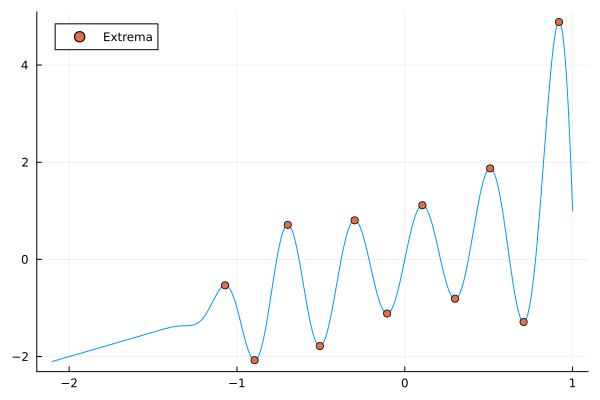

In [8]:
# f(x) = sinpi(x)
dom = [-2.1, 1]
a = cheb(f, dom)
ia = interval(a)
ib = chebdiff(ia, dom)
ix = chebroots(ib, dom)
x = mid.(ix)
# plt = plot()
plot(f, dom[1], dom[2]; label="")
scatter!(x, f.(x); label="Extrema")

### 3. 元のChebyshev補間の端点の値と極大値・極小値を比較し、最大・最小値を求める

係数から端点の関数値を計算する。

$$
    p(-1) = \sum_{n=0}^{M-1} (-1)^na_n,\quad p(1) = \sum_{n=0}^{M-1} a_n.
$$


In [9]:
function endpoints_of_cheb(ia::Vector{Interval{T}}) where {T} # Input is two-sided Chebyshev
    n = length(ia)
    atm1 = dot(interval((-1) .^ (0:n-1)), ia) # endpoint at -1
    at1 = sum(ia) # endpoint at 1
    return [atm1, at1]
end

endpoints_of_cheb (generic function with 2 methods)

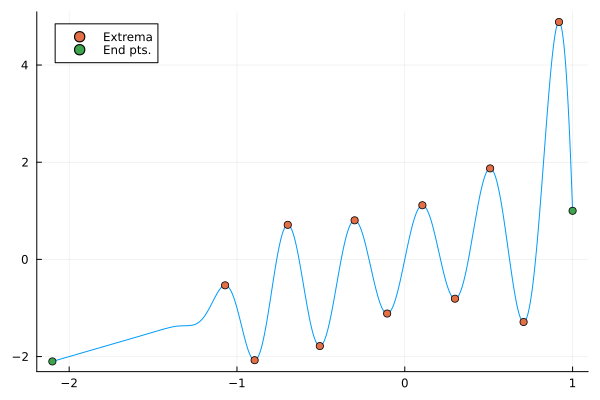

In [10]:
ep = endpoints_of_cheb(ia)
ex = dom
scatter!(ex, mid.(ep); label="End pts.")

得られた端点の値と極大値・極小値を比較し最大値、最小値を求める。これをまとめた関数 `chebmax`, `chebmin` を用意する。

In [11]:
function chebmax(ia, I=[-1, 1]) # Input is two-sided Chebyshev
    I_lo = I[1]
    I_up = I[2]
    M = length(ia)
    ib = chebdiff(ia, I)
    ix = chebroots(ib)
    k = 0:M-1
    fxc = cos.(interval(Vector(k))' .* acos.(ix)) * ia
    ep = endpoints_of_cheb(ia)
    fvals = [ep[1]; fxc[1:end]; ep[2]]
    ix = [interval(-1); ix; interval(1)]
    ind = findall(isequal_interval.(fvals, maximum(fvals)))
    # return ix[ind], fvals[ind]
    return fvals[ind], (interval(1.0) .- ix[ind]) .* interval(I_lo) / interval(2.0) + (interval(1.0) .+ ix[ind]) .* interval(I_up) / interval(2.0)
end

chebmax (generic function with 2 methods)

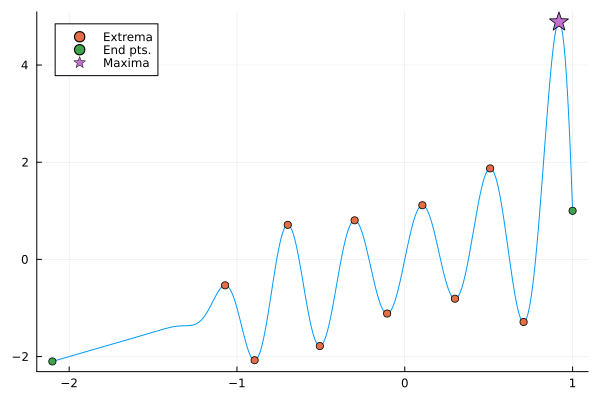

In [12]:
# print(f,-1,1)
fmax, xmax = chebmax(ia, dom)
# scatter!(mid.(xmax),mid.(fmax);legend=false)
scatter!(mid.(xmax), mid.(fmax); label="Maxima", markershape=:star5, markersize=10)

In [13]:
function chebmin(ia, I=[-1, 1]) # Input is two-sided Chebyshev
    I_lo = I[1]
    I_up = I[2]
    M = length(ia)
    M = length(ia)
    ib = chebdiff(ia, I)
    ix = chebroots(ib)
    k = 0:M-1
    fxc = cos.(interval(Vector(k))' .* acos.(ix)) * ia
    ep = endpoints_of_cheb(ia)
    fvals = [ep[1]; fxc[1:end]; ep[2]]
    ix = [interval(-1); ix; interval(1)]
    ind = findall(isequal_interval.(fvals, minimum(fvals)))
    # return ix[ind], fvals[ind]
    return fvals[ind], (interval(1.0) .- ix[ind]) .* interval(I_lo) / interval(2.0) + (interval(1.0) .+ ix[ind]) .* interval(I_up) / interval(2.0)
end

chebmin (generic function with 2 methods)

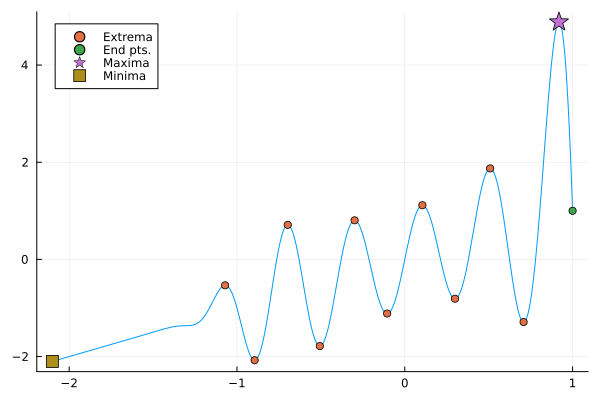

In [14]:
fmin, xmin = chebmin(ia, dom)
# scatter!(mid.(xmin),mid.(fmin),legend=false,xlabel="\$x\$",ylabel="\$f(x)\$",)
scatter!(mid.(xmin), mid.(fmin); label="Minima", markershape=:square, markersize=6)

係数の項数 $M$ が大きいと計算時間がかかってしまう。BLASを使ってないので、大きなサイズの区間行列積の精度保証に時間がかかる。

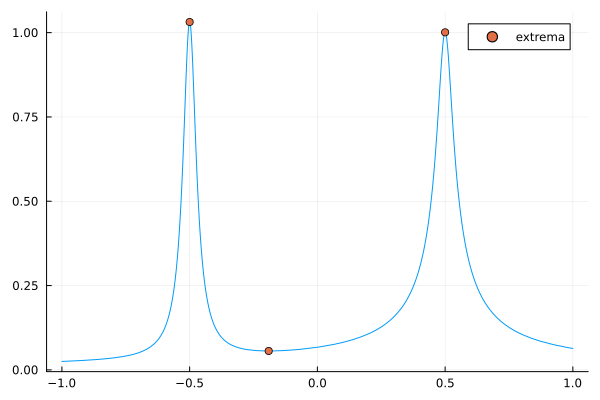

In [15]:
g(x) = 1 / (1 + 1000 * (x + 0.5)^2) + 1 / sqrt(1 + 1000 * (x - 0.5)^2)

a = cheb(g)
ia = interval(a)
ib = chebdiff(ia)
ix = chebroots(ib)
x = mid.(ix)

plot(g, -1, 1; label="")
scatter!(x, g.(x); label="extrema")

In [16]:
radius.(ix)

3-element Vector{Float64}:
 6.63136212608606e-13
 7.971445725729609e-11
 7.285283487590277e-13

## まとめ

Chebyshev補間で与えられた関数の最大値・最小値をChebyshev係数から計算する方法を紹介し、区間演算を用いた精度保証付き数値計算方法についても紹介した。与えた関数 $f(x)$ とそのChebyshev補間 $p(x)$ の間の補間誤差を得ていないため、**$f(x)$ の真の最大・最小値ではない**。今後、$f(x)$ の関数としての区間包含をChebyshev補間で得て、真の最大・最小値の精度保証付き数値計算を実行したい。

本資料は以下のような文献・Web ページ等を参考に書いています。

### 参考文献


1. Lloyd N. Trefethen, Approximation Theory and Approximation Practice, Extended Edition, SIAM, 2019.<br>
(補間理論のマニアックな教科書、18章にChebyshev級数の零点をColleague Matrixを利用して計算する方法が紹介されている。Chebfunを使って実例を見せながら理解させる書き方はとても面白く分かりやすい。本文章のお手本である)

1. 近藤慎佑, 高安亮紀, Chebyshev補間の微分, [https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebdiff.html](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebdiff.html).<br>
(Chebyshev補間の微分を係数操作によって行う方法を紹介している)

1. 近藤慎佑, 高安亮紀, Chebyshev補間の求根, [https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebroot.html](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebroot.html).<br>
(Chebyshev補間の零点の計算を係数操作によって行う方法を紹介している)

<div align="right">近藤慎佑, <a href="http://www.risk.tsukuba.ac.jp/~takitoshi/">高安亮紀</a>, 2024年2月7日（最終更新：2024年3月25日）</div>